In [1]:
import numpy
import os
import pandas
import pandas_datareader
import requests
import yfinance

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS, RollingWLS

import seaborn as sns
import matplotlib.pyplot as plt

import equity_risk_model

import warnings
warnings.filterwarnings('ignore')

# 1 Introduction

Factor models can be used to decompose the risk and returns of an asset (or a collection of assets).

Essentially, we express the returns of a universe of assets in the following form,

$$ R_{i}^{t} = \alpha_{i} + \sum_{i=1}^{N} \beta_{ij}^{t} F_{j}^{t} + \epsilon_{i}^{t} $$

where,

* $R_{i}^{t}$ is the return of asset $i$ at time $t$,
* $\beta_{ij}^{t}$ is the loading on factor $j$ from asset $i$ at time $t$,
* $F_{j}^{t}$ is the factor return of factor $j$ at time $t$,
* $\alpha_{i}^{t}$ is the expected return of asset $i$,
* $\epsilon_{i}^{t}$ is the asset idiosyncratic return of asset $i$ at time $t$.

It follows that the covariance matrix of asset returns $R^{t}$ can be expressed as the sum of a low-rank matrix and a sparse matrix,

$$ \Sigma_{r, t} = B_t \Sigma_{f, t} B_t + \Sigma_{\epsilon, t} $$

where $\Sigma_{f, t} \in \mathbb{R}^{M \times M}$ is the covariance matrix associated with $F^t$ and $\Sigma_{\epsilon, t} \in \mathbb{R}^{N \times N}$ is the covariance matrix associated with $\epsilon^{t}$. Note that $M$, the number of factors, is typically much smaller than $N$, the number of assets.

There are three general approaches to creating a factor model, each with its pros and cons:

| Name   | Approach  | Data Requirements | Performance and Interpretability  |  
|---|---|---|---|
| Fundamental | Loadings are known, estimate factor returns   | High  | High  | 
| Time-Series  | Factor returns are known, estimate factor loadings  | Medium  | Medium  | 
| Statistical  | Estimate both factor loadings and returns  | Low  | Low  | 

In this notebook, we'll use the time-series approach by making use of factor returns data from [Kenneth French's Data Library](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) and stock returns data from Yahoo Finance using [yfinance](https://github.com/ranaroussi/yfinance). The aim is to perform regression to estimate factor loadings enabling us to perform and risk and return attribution.

### References

* Grinold, R. C., & Kahn, R. N. (2000). Active portfolio management. (Chapter 3)
* Fama, E. F., & French, K. R. (1992). The cross‐section of expected stock returns. the Journal of Finance, 47(2), 427-465.
* Fama, E. F., & French, K. R. (1993). Common risk factors in the returns on stocks and bonds. Journal of financial economics, 33(1), 3-56.
* Fama, E. F., & French, K. R. (2015). A five-factor asset pricing model. Journal of financial economics, 116(1), 1-22.

# 2 Data scraping and scrubbing

## 2.1 Factor Data

We'll use `pandas_datareader` to pull some factor returns from [Kenneth French's Data Library](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html).

In particular, we'll grab returns for the following factors:

|Symbol|Description|
|---|---|
|MKT| Market|
|RF | Risk-free|
|SMB| Size (small minus big)|
|HML| Value (high minus low)|
|RMW| Profitability (robust minus weak)|
|CMA| Investment (conservative minus aggressive)|
|UMD| Momentum (up minus down)|
|STR| Short-term reversal|
|LTR| Long-term reversal|

In [2]:
start_date = "1950-01-01"

# MKT, SMB, HML, RMW, CMA, RF, UMD, STR, LTR
facs = [
    "F-F_Research_Data_5_Factors_2x3_daily",
    "F-F_Momentum_Factor_daily",
    "F-F_ST_Reversal_Factor_daily",
    "F-F_LT_Reversal_Factor_daily",
]

dfs = []

for fac in facs:
    dfs.append(pandas_datareader.DataReader(fac, "famafrench", start_date)[0])

factor_returns = (
    pandas.concat(dfs, axis=1)
    .rename(columns={
        'Mkt-RF': 'MKT',
        'Mom   ': 'UMD',
        'ST_Rev': 'STR',
        'LT_Rev': 'LTR'})
    .div(100)
    .assign(MKT_RF=lambda x: x["MKT"] - x["RF"])
)

In [3]:
factor_returns.tail()

,MKT,SMB,HML,RMW,CMA,RF,UMD,STR,LTR,MKT_RF
Date,,,,,,,,,,
2023-11-24,0.0011,0.0062,0.0019,-0.0051,0.0024,0.00021,-0.0031,0.0022,0.0036,0.00089
2023-11-27,-0.0023,-0.0014,-0.0008,0.0012,-0.0025,0.00021,0.0079,-0.0060,-0.0023,-0.00251
2023-11-28,0.0006,-0.0030,0.0005,-0.0017,0.0002,0.00021,-0.0061,0.0022,0.0025,0.00039
2023-11-29,0.0001,0.0058,0.0069,-0.0078,-0.0006,0.00021,-0.0097,-0.0077,0.0023,-0.00011
2023-11-30,0.0035,-0.0041,0.0001,-0.0011,0.0019,0.00021,0.0018,0.0079,0.0025,0.00329


In [4]:
def cumulative_returns(returns, starting_value=1):
    return numpy.cumprod(1 + returns, axis=0) - 1    

We plot the cumulative return of some factors since 2015...

<Axes: xlabel='Date'>

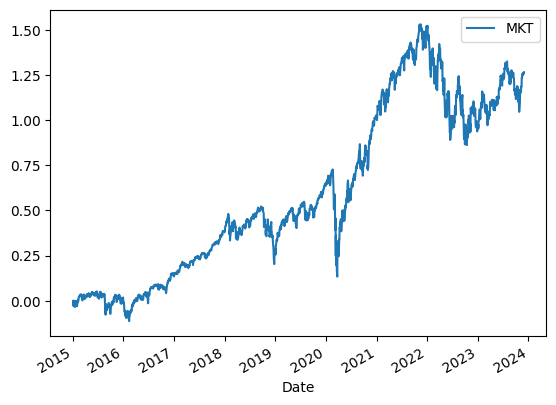

In [5]:
cumulative_returns(factor_returns.loc['2015-01-01':][['MKT']]).plot()

<Axes: xlabel='Date'>

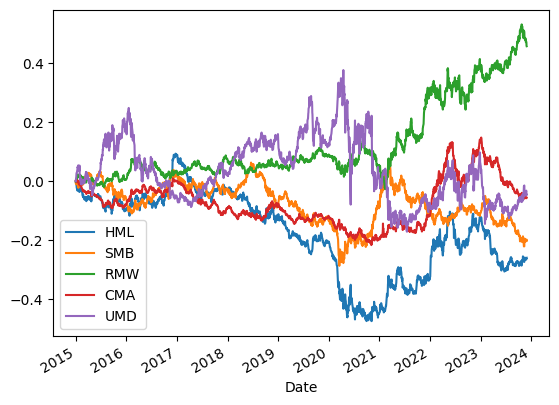

In [6]:
cumulative_returns(factor_returns.loc['2015-01-01':][['HML', 'SMB', 'RMW', 'CMA', 'UMD']]).plot()

<Axes: xlabel='Date'>

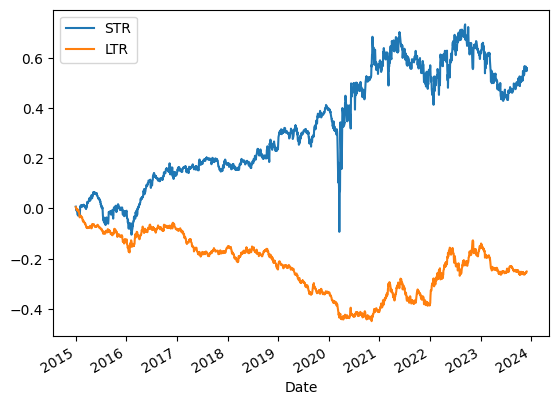

In [7]:
cumulative_returns(factor_returns.loc['2015-01-01':][['STR', 'LTR']]).plot()

## 2.2 Stock Data

We'll make use of `yfinance` to pull adjusted close prices for current constituents of Nasdaq 100,

In [8]:
# Pull current constituents from Wikipedia
nasdaq_100 = pandas.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4]

# Create list of tickers
nasdaq_tickers = nasdaq_100['Ticker'].tolist()

# Download adjusted close prices using yfinance
prices = yfinance.download(" ".join(nasdaq_tickers))['Adj Close']

[*********************100%%**********************]  101 of 101 completed


In [9]:
def simple_returns(prices):
    return numpy.divide(numpy.diff(prices, axis=0), prices[:-1])

# Convert prices to returns
stock_returns = simple_returns(prices)

<Axes: xlabel='Date'>

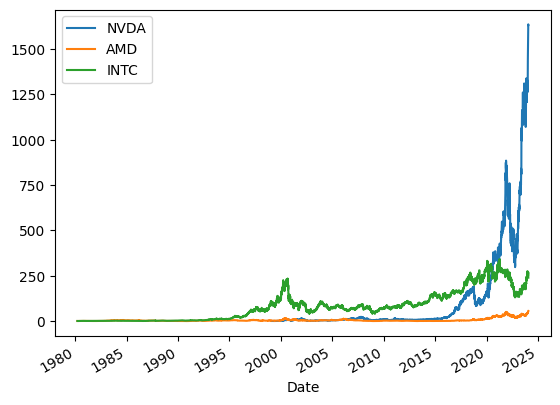

In [10]:
# Cumulative return of some stocks
cumulative_returns(stock_returns[['NVDA', 'AMD', 'INTC']]).plot()

## 3 Estimate Factor Loadings

We can consider the three models from the academic literature,
* Fama-French 3-Factor Model
* Fama-French 5- Factor Model
* Price-Signal Model

In [11]:
models = {
    'Fama-French 3-Factor Model': ['MKT_RF', 'SMB', 'HML'],
    'Fama-French 5-Factor Model': ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA'],
    'Price-Signal Model': ['MKT_RF', 'UMD', 'STR', 'LTR']
}

## 3.1 Fama-French 5 Factor Model

In [12]:
# Let's consider the period from 2010 to the end of 2020
start_date = pandas.Timestamp('2010-01-01')
end_date = pandas.Timestamp('2021-12-31')

# Note stock returns are shifted to properly align against factor returns in the regression
s_returns = stock_returns.shift(1).loc[start_date:end_date]
f_returns = factor_returns.loc[start_date:end_date]

### Single stock example - GOOG

Here, the endogenous variable is the stock return (minus the risk-free rate) and the exogenous variables are the factor returns. 

To check the machinery of our approach, we perform ordinary least squares regression with one years worth of data and cross-check our results against the website portfolio visualiser - see [here](https://www.portfoliovisualizer.com/factor-analysis?s=y&sl=yQKMNuhNJi5Jg9nAoUFrB).

In [13]:
ss = s_returns.loc["2015-01-01": "2016-01-01"]["GOOG"]
fr = f_returns.loc[ss.index]

endog = ss - fr["RF"]

exog_vars = models['Fama-French 5-Factor Model']
exog = sm.add_constant(fr[exog_vars])

In [14]:
mod = sm.OLS(endog, exog).fit()

print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     35.96
Date:                Fri, 26 Jan 2024   Prob (F-statistic):           1.43e-27
Time:                        15:51:37   Log-Likelihood:                 716.37
No. Observations:                 252   AIC:                            -1421.
Df Residuals:                     246   BIC:                            -1400.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.830      0.4

In [15]:
print(f"Daily alpha = {mod.params['const'] * 10_000:.2f} bps")
print(f"Annualised alpha = {mod.params['const'] * 252 * 100:.2f}%")

Daily alpha = 7.53 bps
Annualised alpha = 18.97%


Over this period, we can find that:
* The daily $\alpha$ is 7.53 bps or 18.97% annualised
* The market loading is 0.91, which we would anticipate due to `GOOG` large market capitalisation.
* Negative loadings on `SMB` and `CMA`
* Positive loading on `HML` and `RMW`

#### Rolling OLS Regression

Now we perform a rolling OLS regression with a window of 126 days.

In [16]:
ss = s_returns["GOOG"].dropna()
fr = f_returns.loc[ss.index]

endog = ss - fr["RF"]

exog_vars = models['Fama-French 5-Factor Model']
exog = sm.add_constant(fr[exog_vars])

In [17]:
mod = RollingOLS(endog, exog, window=252).fit()

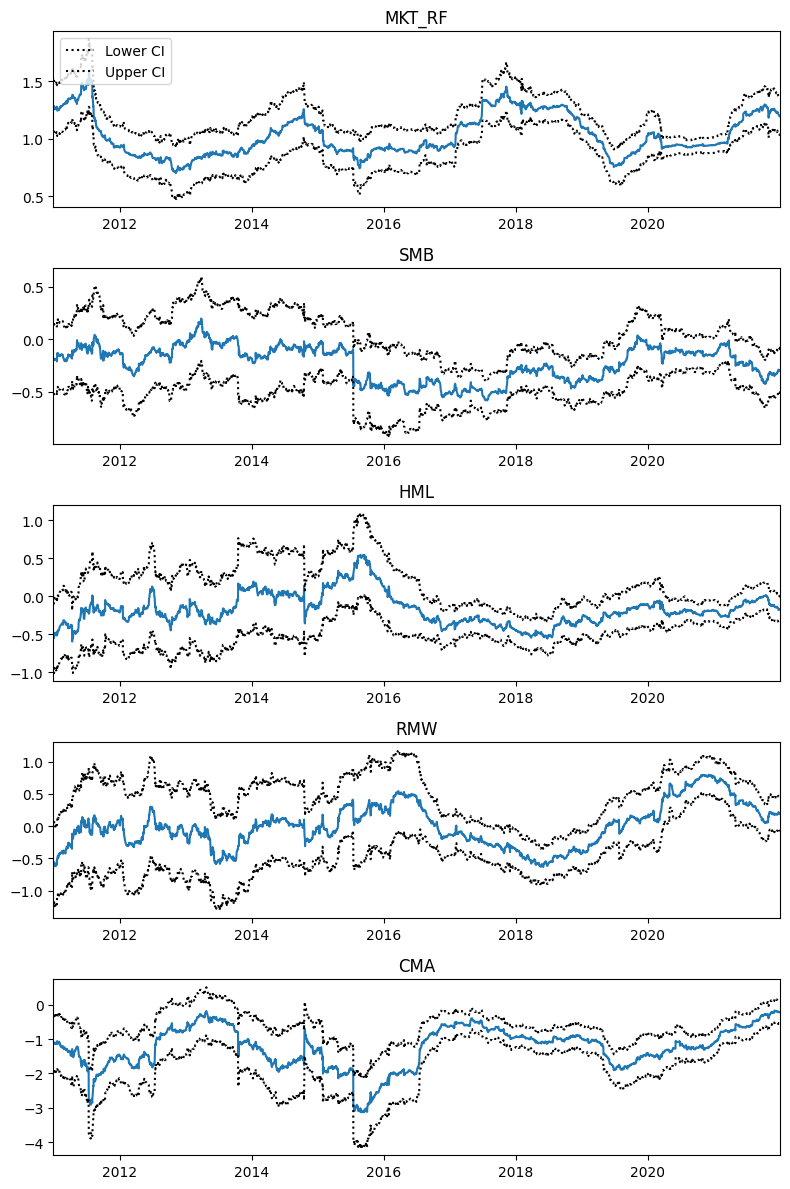

In [18]:
fig = mod.plot_recursive_coefficient(variables=exog_vars, figsize=(8, 12))

Text(0.5, 0, 'Date')

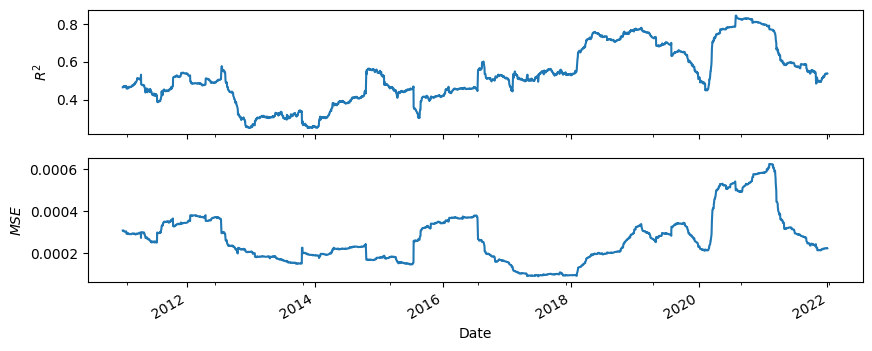

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

mod.rsquared.plot(ax=ax1)
ax1.set_ylabel("$R^2$")

mod.mse_total.plot(ax=ax2)
ax2.set_ylabel("$MSE$")

ax2.set_xlabel("Date")

### Over the complete universe

We repeat the rolling OLS calculation but for each asset in the universe we are considering and store the factor loadings.

As statsmodels does not support a vector of endogeneous variables, we iterate through the tickers.

In [20]:
loadings = []
window = 126

for ticker in nasdaq_tickers:

    endog = s_returns[ticker] - f_returns["RF"]

    if endog.dropna().empty:
        # No data, go to next ticker
        continue

    exog_vars = models['Fama-French 5-Factor Model']
    exog = sm.add_constant(f_returns[exog_vars])
    exog = f_returns[exog_vars]

    out = RollingOLS(endog, exog, window=window).fit()
 
    # Re-arrange loadings and append
    loadings.append(
        out.params
        # .drop(['const'], axis=1)
        .shift(1)
        .dropna()
        .reset_index()
        .melt(
            id_vars=['Date'],
            value_vars=exog_vars,
            var_name='Factor',
            value_name='Loading'
        )
        .assign(Ticker=ticker)
        .set_index(keys=['Date', 'Ticker', 'Factor'])
        .sort_index()
    )
    
loadings = pandas.concat(loadings).sort_index()

In [21]:
loadings.head()

Loading
Date       Ticker Factor          
2010-07-06 AAPL   CMA    -0.716903
                  HML    -0.553864
                  MKT_RF  1.325327
                  RMW    -0.046238
                  SMB     0.478623

# 4 Attribution

## 4.1 Return Attribution

Now that we have an estimate of the factor loadings. We can now decompose the returns of each asset into contributions from each factor as well as an idiosyncratic contribution.

In [22]:
# Re-arrange factor returns
fr = (
    factor_returns[exog_vars]
    .reset_index()
    .melt(
        id_vars=['Date'],
        value_vars=exog_vars,
        var_name='Factor',
        value_name='Factor Return'
    )
    .set_index(keys=['Date', 'Factor'])
    .sort_index()
    [start_date:end_date]
)

# Re-arrange stock returns
sr = (
    s_returns
    .reset_index()
    .melt(
        id_vars=['Date'],
        var_name='Ticker',
        value_name='Total'
    )
    .set_index(keys=['Date', 'Ticker'])
    .sort_index()
    .fillna(value=0)
)

In [23]:
factor_attribution = (
    loadings
    .join(fr)
    .assign(asset_factor_return=lambda x: x['Loading']*x['Factor Return'])
    .reset_index()
    .pivot_table(index=['Date', 'Ticker'], columns='Factor', values='asset_factor_return')
    .sort_index()
)

factor_group_attribution = (
    factor_attribution   
    # Total factor return is the sum over each factor's contribution
    .assign(Factor=lambda x: x.sum(axis=1))
    .join(sr)
    # Specific return is the total return minus total factor return
    .assign(Specific=lambda x: x['Total'] - x['Factor'])
    .filter(items=["Total", "Factor", "Specific"])
)

In [24]:
factor_attribution.head()

Factor                  CMA       HML    MKT_RF       RMW       SMB
Date       Ticker                                                  
2010-07-06 AAPL    0.003154 -0.000609  0.004360 -0.000018 -0.009381
           ADBE    0.004770  0.000439  0.003822  0.000329  0.007012
           ADI    -0.002652 -0.000489  0.003999 -0.000318 -0.000931
           ADP    -0.001264 -0.000543  0.002961 -0.000076  0.002880
           ADSK    0.006295  0.000511  0.004545  0.000212 -0.012724

In [25]:
factor_group_attribution.head()

Total    Factor  Specific
Date       Ticker                              
2010-07-06 AAPL    0.006844 -0.002494  0.009338
           ADBE   -0.014590  0.016373 -0.030963
           ADI     0.000718 -0.000391  0.001108
           ADP    -0.000507  0.003957 -0.004465
           ADSK   -0.010695 -0.001162 -0.009534

### Return Attribution - GOOG

Let's examine GOOG...

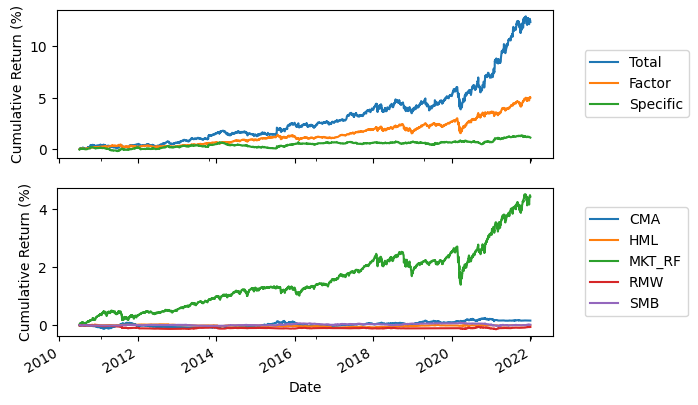

In [26]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

(
    factor_group_attribution.swaplevel(0, 1, 0).loc["GOOG"]
    .apply(cumulative_returns)
).plot(ax=ax1)

ax1.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
ax1.set_ylabel("Cumulative Return (%)")

(
    factor_attribution.swaplevel(0, 1).loc["GOOG"]
    .apply(cumulative_returns)
).plot(ax=ax2)
ax2.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
ax2.set_ylabel("Cumulative Return (%)");

In the above example, we find that most of the returns are due to the market factor.

## 4.2 Risk Attribution

In order to perform risk attribution we need to calculate the covariance matrix for both factor returns and specific returns.

### Estimate Factor Covariance Matrix

Here, we can just use a rolling calculation over the exogenous variables in the factor model of interest.

In [27]:
covariance_factor = (
    factor_returns[start_date:end_date][exog_vars]
    .rolling(window=252, min_periods=21)
    .cov()
    .multiply(252)
)

In [28]:
covariance_factor.loc['2019-12-31']

,MKT_RF,SMB,HML,RMW,CMA
MKT_RF,0.017041,0.002647,-0.001182,-0.000090,-0.002500
SMB,0.002647,0.006223,0.002243,-0.000217,-0.000024
HML,-0.001182,0.002243,0.008699,0.001479,0.002148
RMW,-0.000090,-0.000217,0.001479,0.002612,0.000569
CMA,-0.002500,-0.000024,0.002148,0.000569,0.002057


### Estimate Specific Covariance Matrix

Here, we calculate the rolling standard deviation of the specific returns of each asset.

In [29]:
covariance_specific = (
    factor_group_attribution[['Specific']]
    .reset_index()
    .pivot_table(
        index='Date',
        columns='Ticker',
        values='Specific')
    .rolling(window=252)
    .var()
    .reset_index()
    .melt(id_vars='Date', value_name='Specific Risk')
    .set_index(keys=['Date', 'Ticker'])
    .sort_index()
)

In [30]:
covariance_specific.tail()

Specific Risk
Date       Ticker               
2021-12-31 WBA          0.000263
           WBD          0.001024
           WDAY         0.000166
           XEL          0.000121
           ZS           0.000390

### Sanity Check - GOOG

In [31]:
date = '2019-12-31'
ticker = 'GOOG'

In [32]:
cov_f = covariance_factor.loc[date].sort_index(axis=0).sort_index(axis=1)
cov_s = covariance_specific.loc[date, ticker].values[0]
l = loadings.loc[date, "GOOG"].sort_index()

In [33]:
factor_risk = numpy.sqrt(l.T @ (cov_f @ l)).iloc[0, 0]
print(f"The factor risk is:\t {factor_risk*100:.2f}%")

specific_risk = numpy.sqrt(cov_s)
print(f"The specific risk is:\t {specific_risk*100:.2f}%")

total_risk = numpy.sqrt(cov_s + factor_risk**2)
print(f"The total risk is:\t {total_risk*100:.2f}%")

The factor risk is:	 17.80%
The specific risk is:	 1.09%
The total risk is:	 17.83%


## 5 Using methods from `equity_risk_model`

Now that we've have all the components for an equity risk model, let's use some of the methods to calculate the risk of a portfolio.

### Prepare Risk Model Data

In [34]:
date = '2019-12-31'

factor_loadings = (
    loadings
    .sort_index()
    .loc[date]
    .reset_index()
    .pivot_table(index='Factor', columns='Ticker', values='Loading')
)

universe = factor_loadings.columns.tolist()
factors = factor_loadings.index.tolist()

# Reindex by factors
covariance_factor = cov_f.reindex(factors, axis=0).reindex(factors, axis=1)

# Specific covariance matrix is diagonal
cov_s_temp = covariance_specific.loc[date].fillna(value=0)

covariance_spec = (
    pandas.DataFrame(
        data=numpy.diag(cov_s_temp.values.reshape(-1)),
        index=cov_s_temp.index, columns=cov_s_temp.index
    )
    .reindex(universe, axis=0)
    .reindex(universe, axis=1)
)

# Extract factor group mapping from models dict defined earlier
factor_group_mapping = {k: v for k, v in models.items() if k == "Fama-French 5-Factor Model"}

In [35]:
# Instantiate risk model and risk calculator with the data
risk_model = equity_risk_model.model.FactorRiskModel(
    universe, factors, factor_loadings, covariance_factor, covariance_spec, factor_group_mapping
)

risk_calculator = equity_risk_model.risk.RiskCalculator(risk_model)

conc_calculator = equity_risk_model.concentration.ConcentrationCalculator(risk_calculator=risk_calculator)

### Create some portfolios

#### Naive allocations

Let's create a randomly allocated portfolio and an equally weighted portfolio.

In [36]:
n_assets = len(universe)

In [37]:
dirichlet_portfolio = pandas.Series(
    data=numpy.random.dirichlet(numpy.ones(n_assets)),
    index=universe
)

In [38]:
equal_portfolio = pandas.Series(
    data=numpy.ones(n_assets) / n_assets,
    index=universe
)

In [39]:
portfolios = {
    "Dirichlet": dirichlet_portfolio,
    "Equal": equal_portfolio,
}

### Examine tearsheets

In [40]:
(
    equity_risk_model.tearsheet.FactorRiskSummaryTearsheet(risk_calculator=risk_calculator)
    .create_tearsheet(portfolios)
    .style
    .bar(color=["#d65f5f", "#5fba7d"], width=75, height=50, align="zero")
    .format(lambda x: f"{x * 100:.2f}%")
)

,Dirichlet,Equal
Total,17.50%,16.41%
Factor,17.50%,16.41%
Specific,0.27%,0.17%


In [41]:
(
    equity_risk_model.tearsheet.FactorRiskTearsheet(risk_calculator=risk_calculator)
    .create_tearsheet(portfolios)
    .style
    .bar(color=["#d65f5f", "#5fba7d"], width=75, height=50, align="zero")
    .format(lambda x: f"{x * 100:.2f}%")
)

In [42]:
(
    equity_risk_model.tearsheet.ConcentrationTearsheet(concentration_calculator=conc_calculator)
    .create_tearsheet(portfolios)
    .style
    .format(lambda x: f"{x:.1f}")
    .bar(color=["#d65f5f", "#5fba7d"], width=75, height=50, align="zero")
)

,Dirichlet,Equal
NAssets,96.0,96.0
NCorrelatedBets,34.5,78.3
NUncorrelatedBets,11.9,48.6
NEffectiveConstituents,45.2,96.0
NAssets>25%SpecificRisk,2.0,7.0
NAssets>50%SpecificRisk,4.0,18.0
NAssets>75%SpecificRisk,9.0,41.0
